In [1]:
import os 
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata
import copy
import desc
import matplotlib.pyplot as pl
# following line ensures the pl plots inline 
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
from importlib import reload
import GE_functions
reload(GE_functions)

<module 'GE_functions' from '/data/jlu/Chaperone_Analysis/notebooks/GE_functions.py'>

The goal of this noteobok is to make a rank table of genes associated with Rtp1 / Rtp2 expression trajectory across the lineage of cells from GBC_INP_iOSN_mOSN. Additionally, this Olfr is NOT excluded from gene analysis but rather concatenated as a single Olfr gene in a none discriminatory manner. 
Output should be a datatable containing the different processed counts column with ranks of the genes relatively associated to Rtp1 / Rtp2 calculated by mean square error. 

In [40]:
adata = anndata.read_csv('./files/Brann/GSE151346_MOE_all_counts.csv')
meta_data = pd.read_table('./files/Brann/GSE151346_MOE_metadata.tsv')
meta_data = meta_data.set_index('index')
# transpose used to flip obs and vars.
adata_brann = adata.copy().transpose()

In [41]:
# Subset the adata by only cells included in metadata. Attach meta info onto adata
adata_brann = adata_brann[meta_data.index, :]
adata_brann.obs = adata_brann.obs.join(meta_data).dropna(axis = 0)

In [42]:
# Plotting the provided UMAP coordinates on metafile to visualize 
fig = px.scatter(adata_brann.obs, x='UMAP_1', y= 'UMAP_2', color='leiden_name')
fig.update_traces(marker = dict(size = 3, opacity = 0.5))
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    })
fig.show()

In [43]:
# Subset the adata by interested cells. 
interested_cells = ['mOSN', 'iOSN', 'GBC', 'INP']
interested_cells_id = adata_brann.obs.leiden_name.isin(interested_cells)
adata_brann = adata_brann[interested_cells_id,:]

In [44]:
uOR_list = pd.read_csv('./files/Shayya/bk_rnaseq/uOR_Matsunami.csv')['id'].to_list()
oOR_list = pd.read_csv('./files/Shayya/bk_rnaseq/oOR_Matsunami.csv')['id'].to_list()
oOR_null_list = pd.read_csv('./output/oOR_nullexp.csv')['Olfr'].to_list()

In [45]:
# convert anndata to pandas in order to manipulate count matrix 
pd_adata = pd.DataFrame(data=adata_brann.X, 
                        index=adata_brann.obs_names, 
                        columns=adata_brann.var_names)
# Concatenating all Olfr genes into a Olfr_sum as gene name
pd_Olfr = pd_adata[pd_adata.columns[pd_adata.columns.str.match('Olfr')]]
# Invert makes a new dataframe without any Olfr genes 
# pd_adata = pd_adata[pd_adata.columns[np.invert(pd_adata.columns.str.match('Olfr'))]]
pd_adata['Olfr_sum'] = pd_Olfr.sum(1)
pd_adata['uOR_sum'] = pd_Olfr[pd_Olfr.columns.intersection(uOR_list)].sum(1)
pd_adata['oOR_sum'] = pd_Olfr[pd_Olfr.columns.intersection(oOR_list)].sum(1)
pd_adata['oOR_null_sum'] = pd_Olfr[pd_Olfr.columns.intersection(oOR_null_list)].sum(1)
matrix = np.matrix(pd_adata)
# Reconstruct adata from pandas df 
obs = pd.DataFrame(index=pd_adata.index)
var = pd.DataFrame(index=pd_adata.columns)
adata_brann = anndata.AnnData(matrix, obs=obs, var=var)
# add meta data back again and save raw
adata_brann.obs = adata_brann.obs.join(meta_data).dropna(axis = 0)
adata_brann.raw = adata_brann

Now at this point, the anndata object we have only contains of GBC_INP_iOSN_mOSN, and additionally the Olfr genes have been concatenated. Now simply continue to perpare for pseudotime analysis

In [46]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata_brann, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata_brann)

In [47]:
adata_brann.var['mt'] = adata_brann.var_names.str.startswith('Mt') 
sc.pp.calculate_qc_metrics(adata_brann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [48]:
# Define genes to be removed from the datasets prior to finding highly variable genes for clustering
mito_genes = adata_brann.var_names.str.startswith('mt-')
malat1 = adata_brann.var_names.str.startswith('Malat')

# Adds the True positions together for a remove list 
remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata_brann = adata_brann[:,keep]
print(adata_brann.n_obs, adata_brann.n_vars)

23977 38350


In [49]:
sc.tl.pca(adata_brann, svd_solver='arpack')
sc.pp.neighbors(adata_brann, n_neighbors=10, n_pcs=40)
sc.tl.draw_graph(adata_brann)
sc.tl.umap(adata_brann)

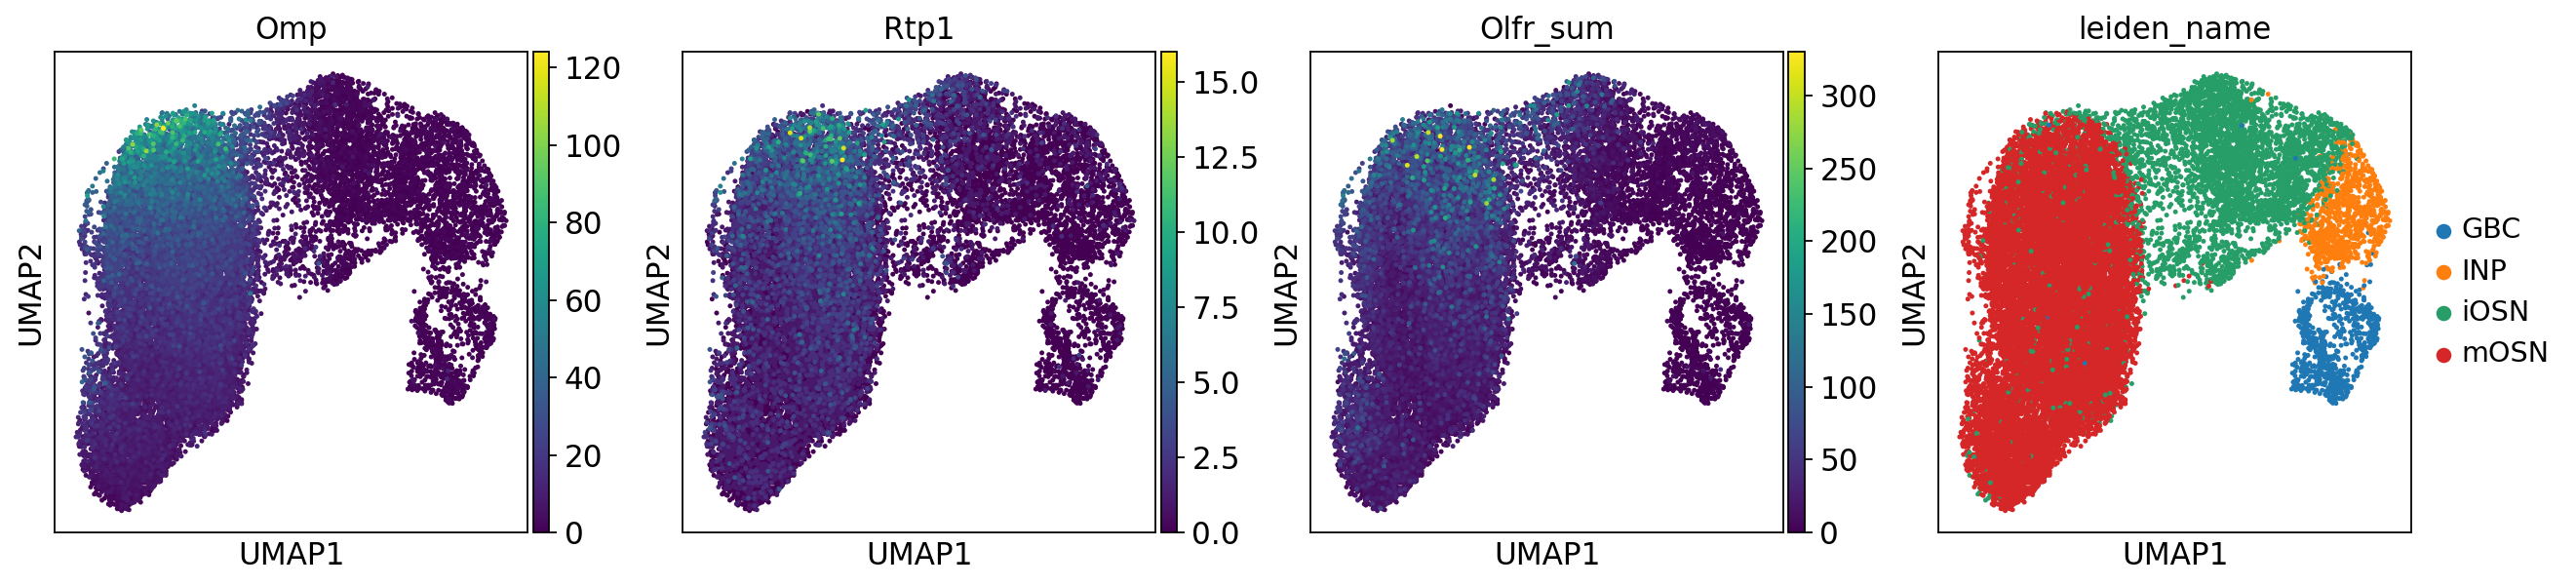

In [77]:
sc.set_figure_params(facecolor='white')
sc.pl.umap(adata_brann, color=['Omp', 'Rtp1','Olfr_sum','leiden_name'], size=20)

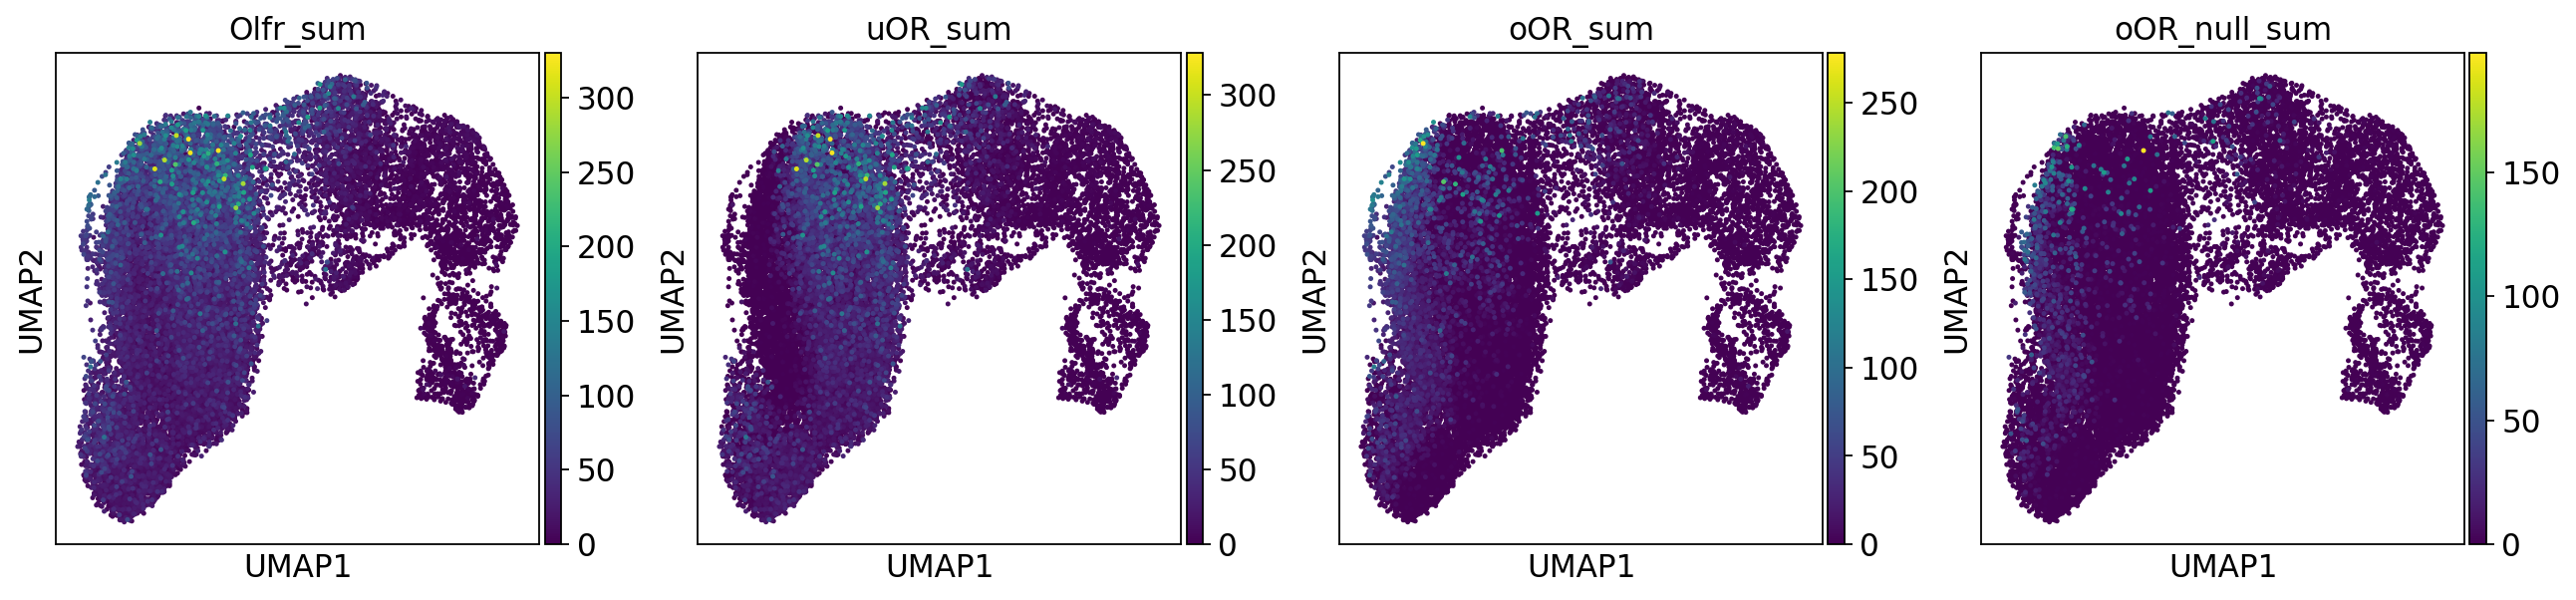

In [51]:
sc.pl.umap(adata_brann, color=['Olfr_sum', 'uOR_sum', 'oOR_sum', 'oOR_null_sum'], size=20)

In [52]:
# Clustering PAGA via leiden clustering method
sc.tl.leiden(adata_brann, resolution = 0.5)
sc.tl.paga(adata_brann, groups='leiden')

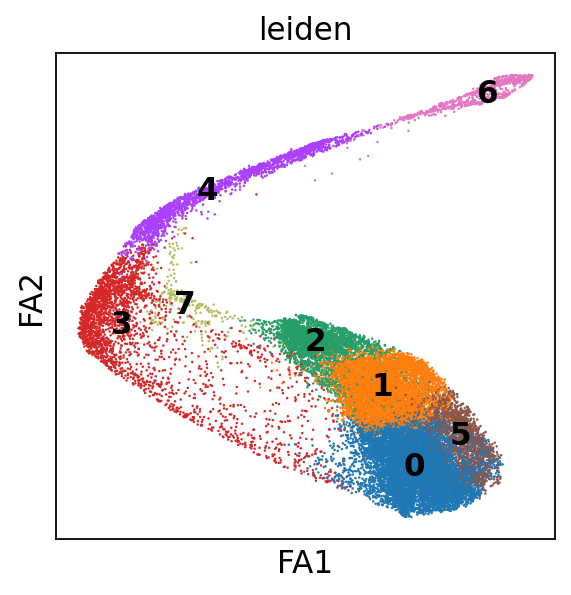

In [53]:
sc.pl.draw_graph(adata_brann, color=['leiden'], legend_loc='on data')

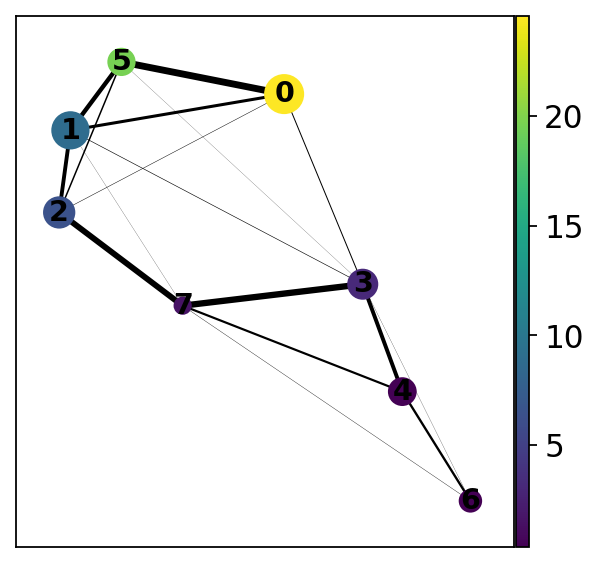

In [54]:
sc.pl.paga(adata_brann, color=['Omp'])

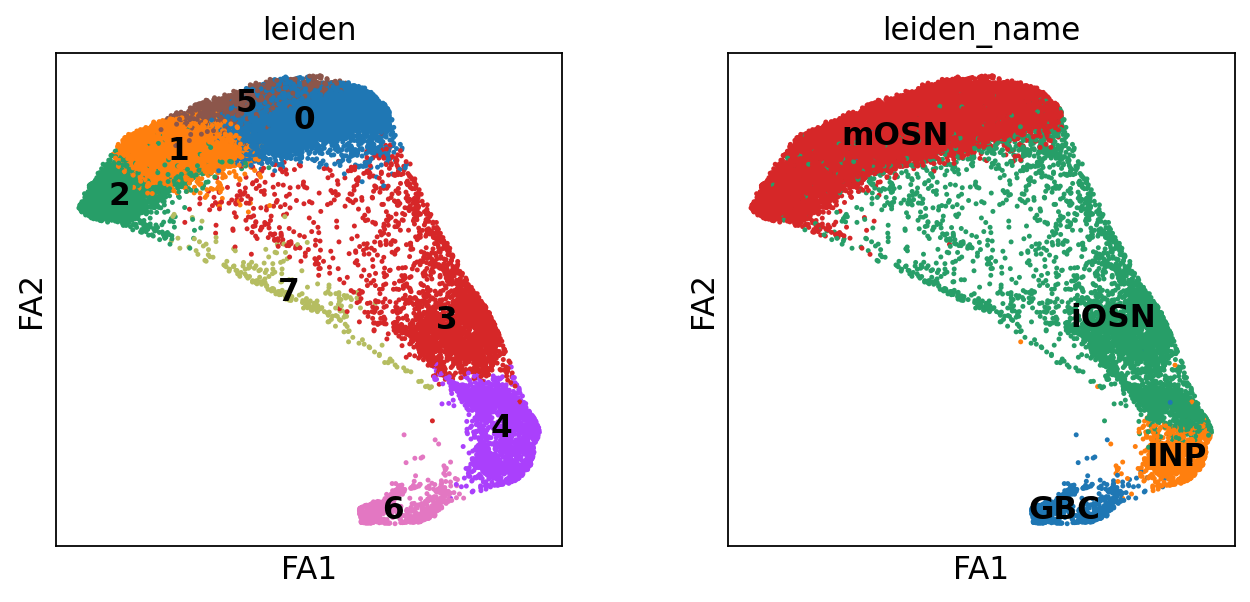

In [78]:
sc.tl.draw_graph(adata_brann, init_pos='umap')
sc.pl.draw_graph(adata_brann, color=['leiden', 'leiden_name'], legend_loc='on data', size=20)

In [56]:
# Save data with the raw counts
adata = adata_brann.raw.to_adata()
adata.write('./files/Brann/GSE151346_MOE_ALL_Olfr.h5ad') 

In [4]:
adata = desc.read_h5ad('../files/Brann/GSE151346_MOE_ALL_Olfr.h5ad')

In [58]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution = 1)
sc.tl.paga(adata, groups='leiden')

In [59]:
# Store raw counts in adata.raw so we don't lose the values when processing 
adata.raw = adata
adata_log1p = adata.copy()

In [60]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.normalize_total(adata_log1p, target_sum=1e4)
sc.pp.log1p(adata_log1p)

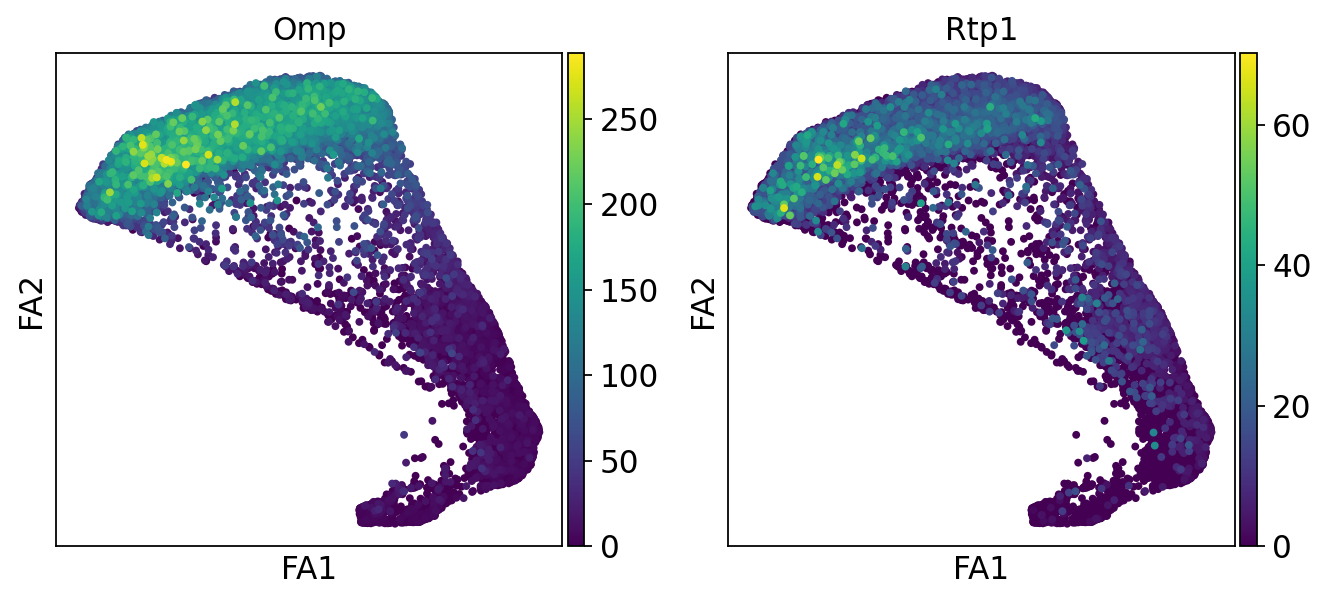

In [61]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['Omp','Rtp1'], legend_loc='on data', size=50, use_raw=False)

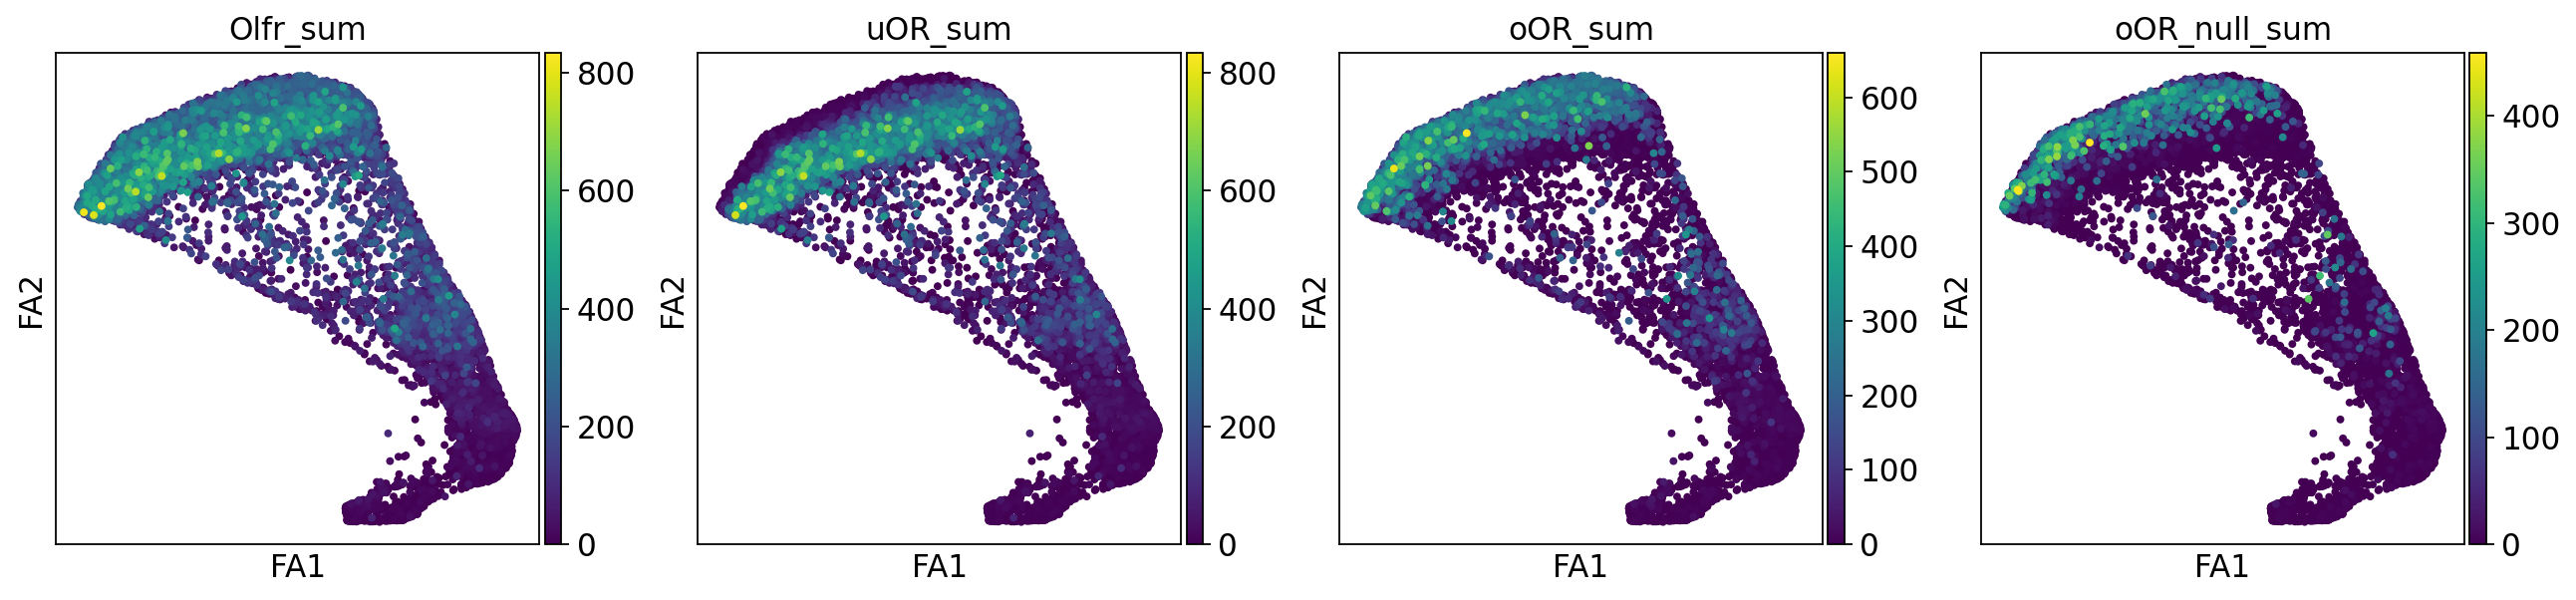

In [62]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['Olfr_sum','uOR_sum', 'oOR_sum','oOR_null_sum'], legend_loc='on data', size=50, use_raw=False)

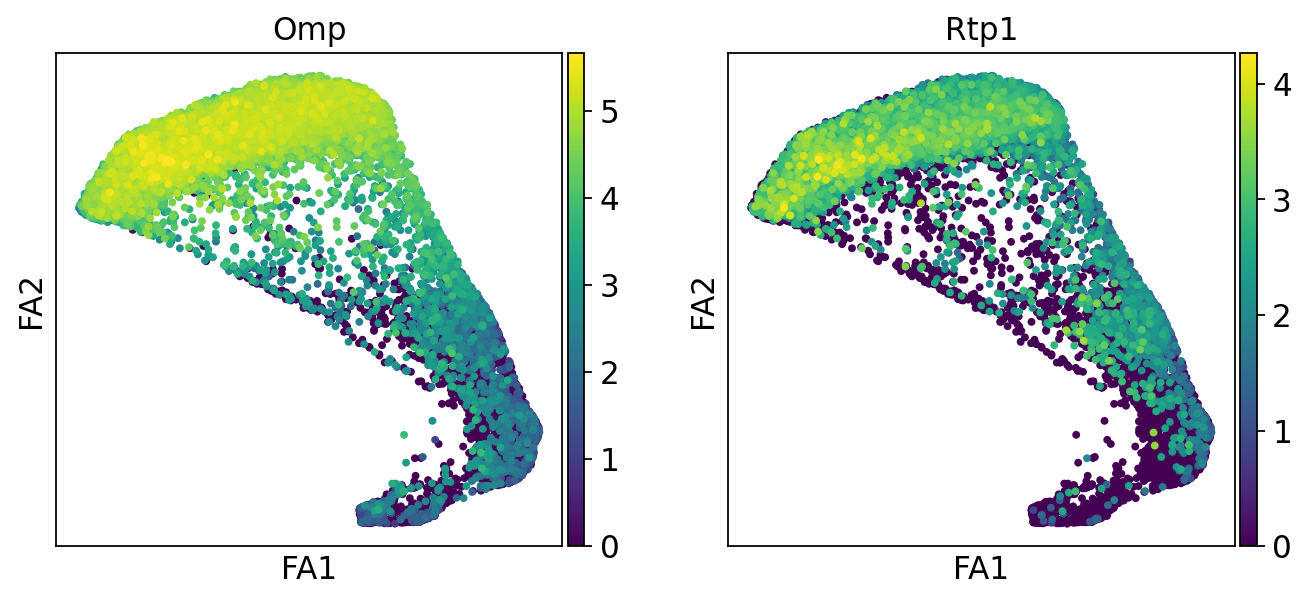

In [63]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata_log1p, color=['Omp','Rtp1'], legend_loc='on data', size=50, use_raw=False)

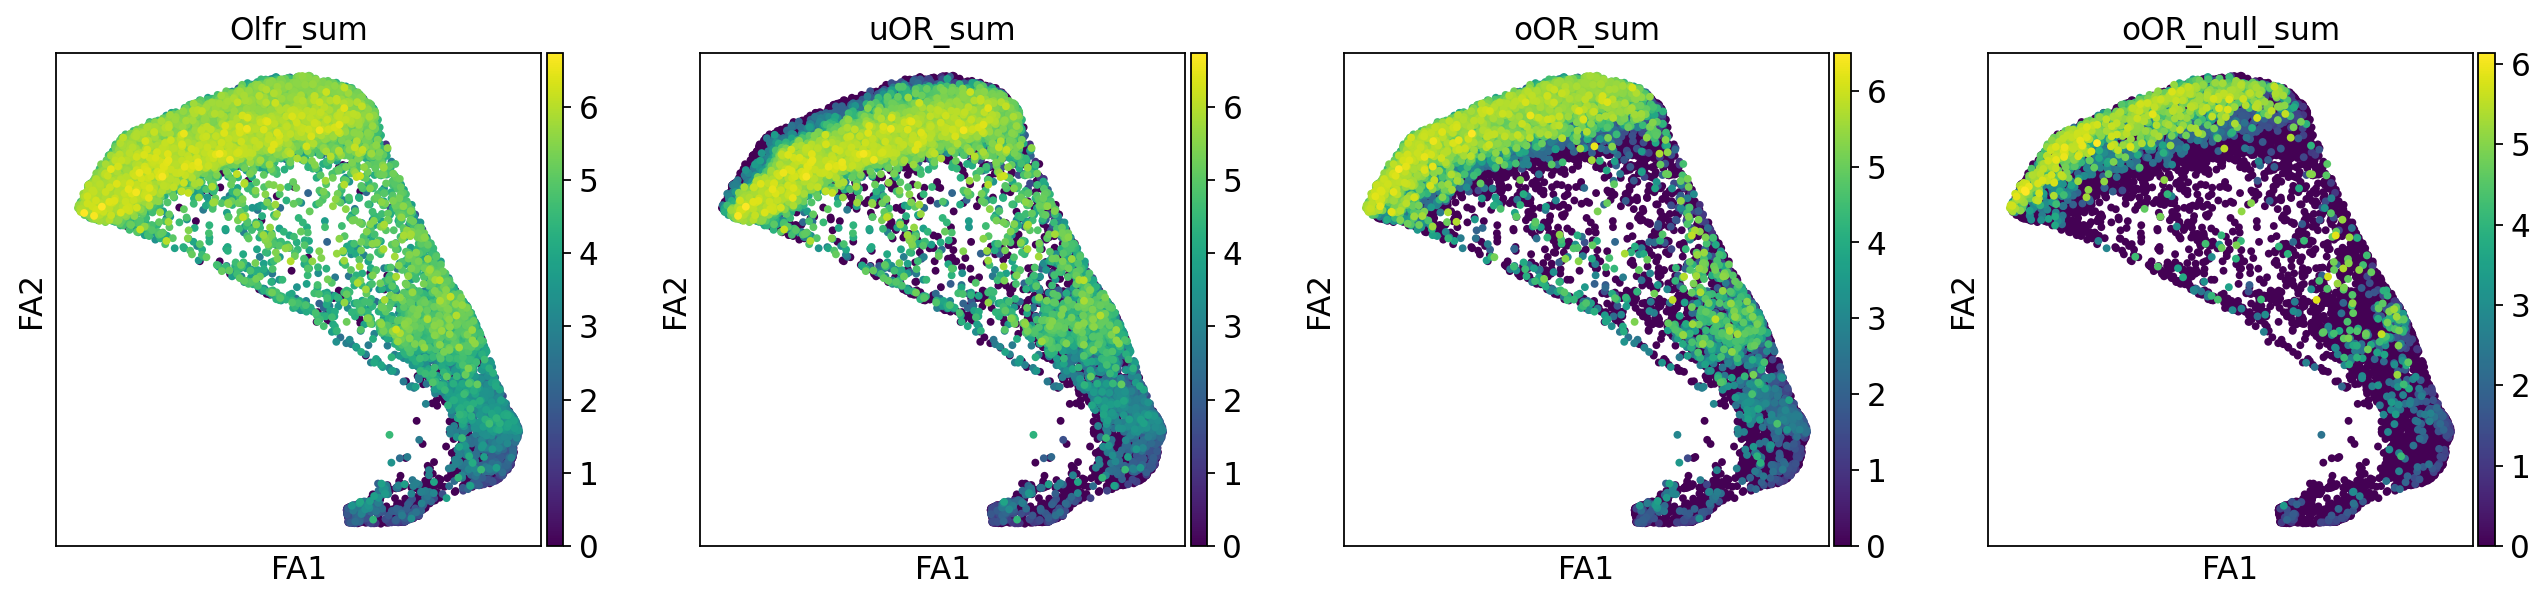

In [64]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata_log1p, color=['Olfr_sum','uOR_sum', 'oOR_sum', 'oOR_null_sum'], legend_loc='on data', size=50, use_raw=False)

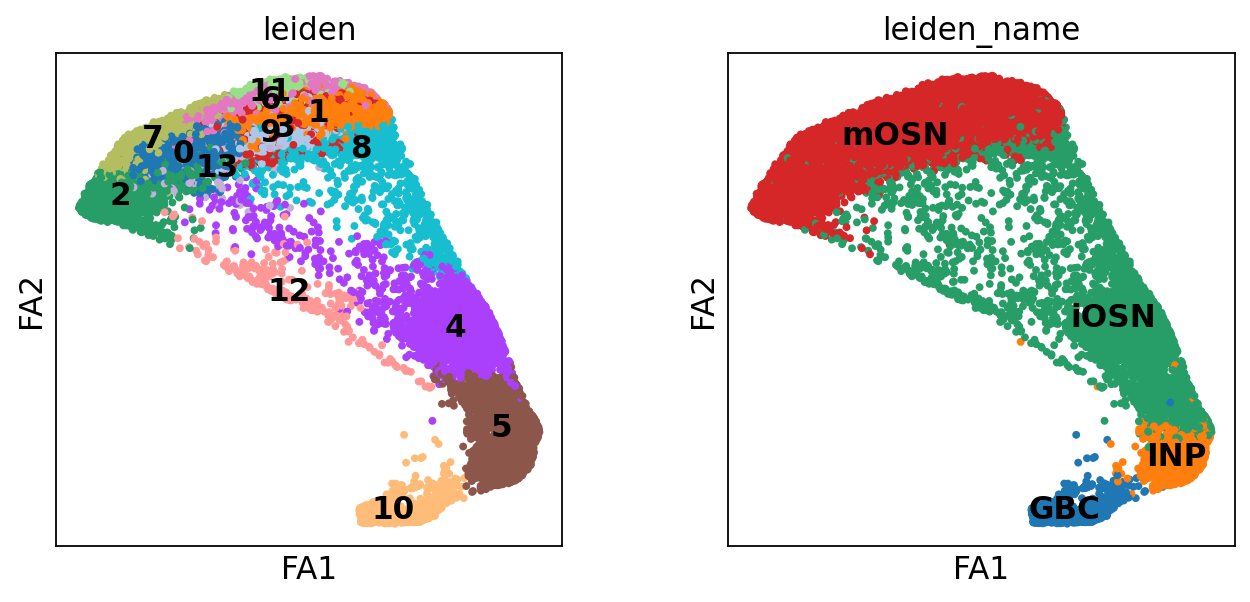

In [65]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata, color=['leiden','leiden_name'], legend_loc='on data', size=50)

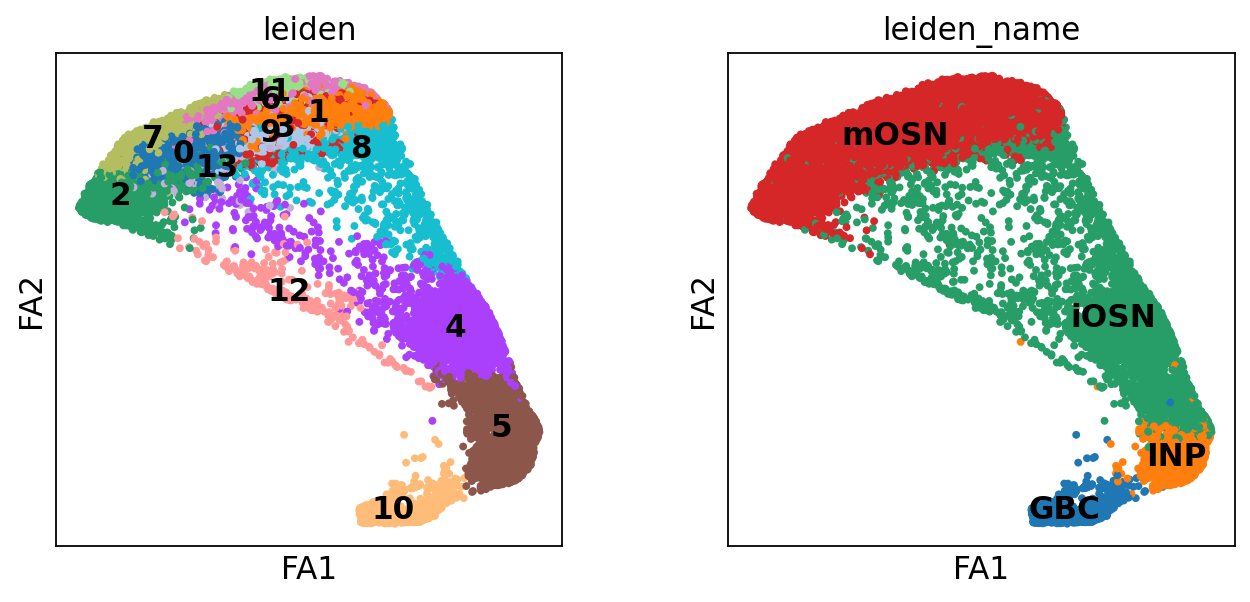

In [66]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(adata_log1p, color=['leiden','leiden_name'], legend_loc='on data', size=50)

In [67]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '10')[0]
sc.tl.dpt(adata)
adata_log1p.uns['iroot'] = np.flatnonzero(adata_log1p.obs['leiden']  == '10')[0]
sc.tl.dpt(adata_log1p)

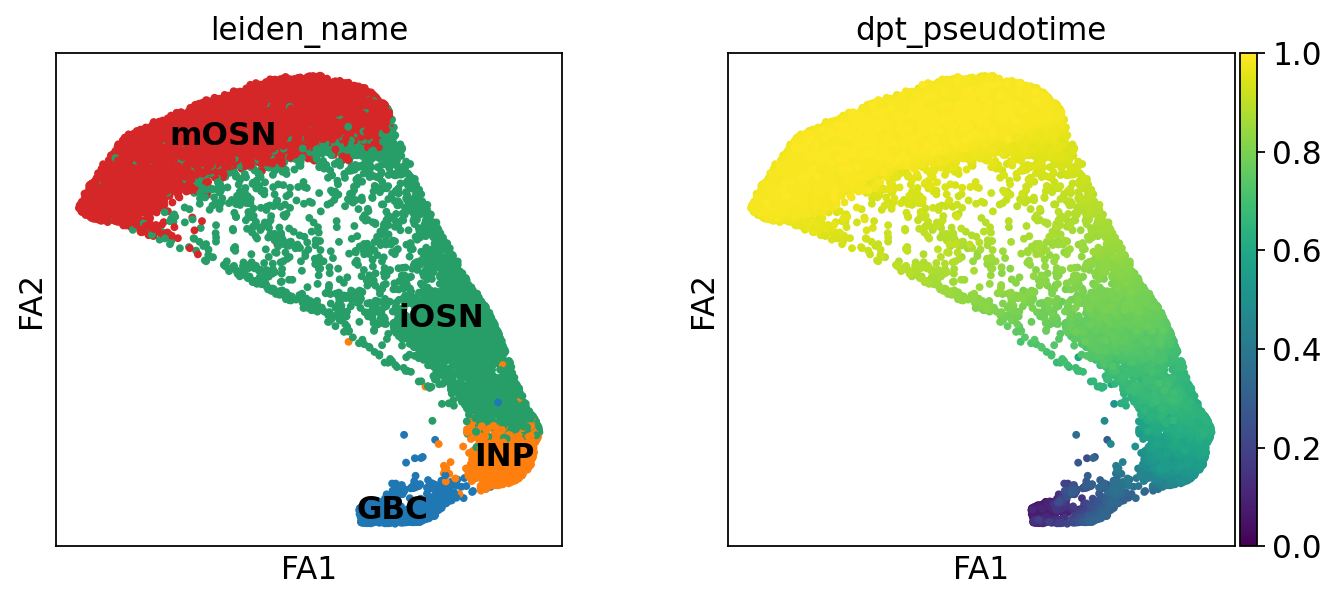

In [68]:
sc.pl.draw_graph(adata, color=['leiden_name', 'dpt_pseudotime'], legend_loc='on data', size=50)

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'selected_dpt' as categorical


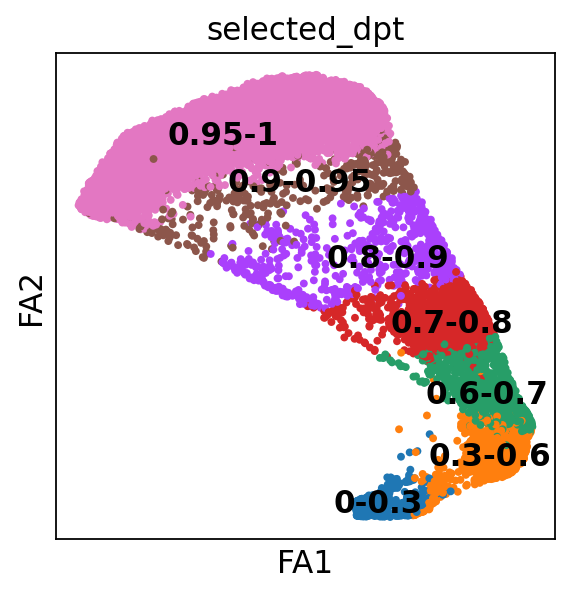

In [69]:
adata = GE_functions.add_selected_dpt(adata, dpt_cutoff=[0,0.3,0.6,0.7,0.8,0.9,0.95,1])
sc.pl.draw_graph(adata, color=['selected_dpt'], legend_loc='on data', size=50)

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

... storing 'selected_dpt' as categorical


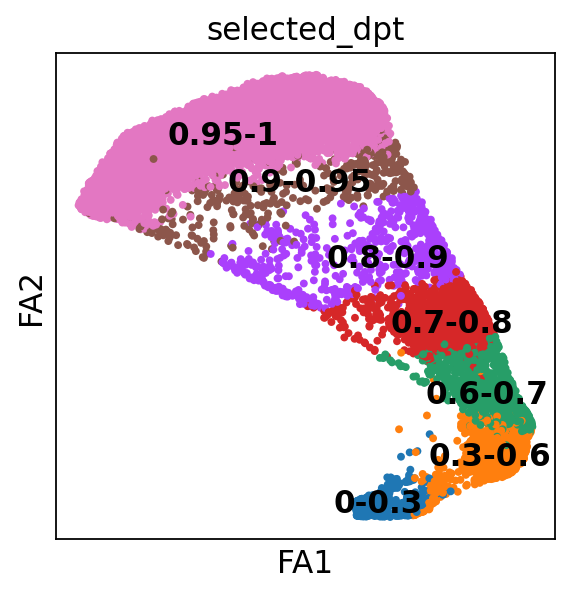

In [70]:
adata_log1p = GE_functions.add_selected_dpt(adata_log1p, dpt_cutoff=[0,0.3,0.6,0.7,0.8,0.9,0.95,1])
sc.pl.draw_graph(adata_log1p, color=['selected_dpt'], legend_loc='on data', size=50)

In [72]:
# Saving normalized adata. Raw contains untouched raw counts. 
adata.write('./files/Brann/GSE151346_MOE_ALL_Olfr.h5ad') 
adata_log1p.write('./files/Brann/GSE151346_MOE_ALL_Olfr_log1p.h5ad') 

In [ ]:
adata = sc.read_h5ad('./files/Brann/GSE151346_MOE_ALL_Olfr.h5ad')
adata_log1p = sc.read_h5ad('./files/Brann/GSE151346_MOE_ALL_Olfr_log1p.h5ad')

In [71]:
gene_names = GE_functions.get_gene_names(adata)
# gene_names.append('Olfr_sum')
gene_names.append('uOR_sum')
gene_names.append('oOR_sum')
gene_names.append('oOR_null_sum')

In [73]:
# construct ge_table FOR BOTH log1p and normalized data. (You don't need both)
ge_normalized = GE_functions.get_ge_table(adata, gene_names, ge_across='selected_dpt')
ge_log1p = GE_functions.get_ge_table(adata_log1p, gene_names, ge_across='selected_dpt')
# convert average gene expression to relative gene expression. (Optional )
ge_normalized = GE_functions.gene_to_relative_expression(ge_normalized)
ge_log1p = GE_functions.gene_to_relative_expression(ge_log1p)
# Construct mse_table from the ge_table values relative to Rtp1(Default)
mse_normalized_rtp1 = GE_functions.get_mse_table(ge_normalized, gene_names)
mse_log1p_rtp1 = GE_functions.get_mse_table(ge_log1p, gene_names)

mse_table constructed
mse_table constructed


In [75]:
ge_normalized.to_csv('./expression_csv/ge_normalized_GSE151346_MOE_ALL_OlfrSum.csv')
mse_normalized_rtp1.to_csv('./expression_csv/mse_normalized_rtp1_GSE151346_MOE_ALL_OlfrSum.csv')
ge_log1p.to_csv('./expression_csv/ge_log1p_GSE151346_MOE_ALL_OlfrSum.csv')
mse_log1p_rtp1.to_csv('./expression_csv/mse_log1p_rtp1_rtp1_GSE151346_MOE_ALL_OlfrSum.csv')

In [151]:
# combining normalized and processed mse_table and save 
mse_combined = mse_normalized_rtp1.transpose().rename(columns = {'mse': 'mse_normalized_normExp_ALL_Olfr_rtp1'}).join(
    mse_log1p_rtp1.transpose().rename(columns = {'mse': 'mse_log1p_normExp_ALL_Olfr_rtp1'}))
mse_combined.to_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp1.csv')

In [ ]:
# calculate mse_table relative to rtp2
mse_normalized_rtp2 = GE_functions.get_mse_table(ge_normalized, gene_names, mse_gene='Rtp2')
mse_log1p_rtp2 = GE_functions.get_mse_table(ge_log1p, gene_names, mse_gene='Rtp2')
# combining normalized and processed mse_table and save 
mse_combined = mse_normalized_rtp2.transpose().rename(columns = {'mse': 'mse_normalized_normExp_ALL_Olfr_rtp2'}).join(
    mse_log1p_rtp2.transpose().rename(columns = {'mse': 'mse_log1p_normExp_ALL_Olfr_rtp2'}))
# mse_combined.to_csv('./output/brann/mse_combined_ALL_Olfr_rtp2.csv')
mse_combined.to_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp2.csv')

In [64]:
mse_combined = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp1.csv', index_col=[0])

In [5]:
gene_names = list(mse_combined.index)
excluded_genes = GE_functions.get_excluded_genes(gene_names)
excluded_genes.append('Olfr_sum')

In [243]:
mse_combined_rtp1 = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp1.csv', index_col=[0])
rank_combined_rtp1 = GE_functions.mse_to_rank(mse_combined_rtp1, col_names=['mse_rank_normalized_normExp_ALL_Olfr_rtp1',
                                                 'mse_rank_log1p_normExp_ALL_Olfr_rtp1'])
mse_combined_rtp2 = pd.read_csv('./output/brann/mse_combined_normExp_ALL_Olfr_rtp2.csv', index_col=[0])
rank_combined_rtp2 = GE_functions.mse_to_rank(mse_combined_rtp2, col_names=['mse_rank_normalized_normExp_ALL_Olfr_rtp2',
                                                 'mse_rank_log1p_normExp_ALL_Olfr_rtp2'])
# For reindexing if ever need to match index to master list 
index_order = pd.read_csv('./output/brann/Rank_gene_combined_ALL_Olfr_rtp1.csv', index_col=[0]).index
rank_combined_rtp1.reindex(index_order).to_csv('./output/brann/Rank_gene_combined_normExp_ALL_Olfr_rtp1.csv')
rank_combined_rtp2.reindex(index_order).to_csv('./output/brann/Rank_gene_combined_normExp_ALL_Olfr_rtp2.csv')

In [66]:
# For the columns in mse_combined (before ranks are added), sort them by the value of the column and add ranks 
for col in mse_combined.columns.unique():
    mse_combined.sort_values(by=col, inplace=True)
    mse_combined[str(col+'_Rank')] = list(range(1,len(mse_combined)+1))

mse_combined.to_csv('./output/brann/rank_mse_combined_normExp_ALL_Olfr_rtp1.csv')